 Versuch 2
 ======
 
 Thema
 ------

Ziel dieses Versuchs ist es mit Hilfe von Clusteranalyse die Merkmale der aufgezeichneten Daten in unterschiedliche   
Rauhigkeitsklassen zu unterteilen. Die Fragestellung ist wie gut die Merkmale mit Clustering gelabelt werden können. Die zu analysierenden   
Daten wurde vorher mit einer Android App aufgenommen.   


 Versuchsaufbau
 ------
 
Die erfassten Daten sollen mit Clustering gelabelt werden. Dafür werden die zu betrachtenden Daten in Form einer bereits bearbeiteten CSV geladen.    
Durch Plots und Informationen der Daten soll analysiert werden, ob die gefunden Klassen sin ergeben. Zu weiteren Verarbeitung der Daten sollen      
die Merkmale um eine Spalte erweitert werden, um die zugeordneten Klassen abzuspeichern. Als Algorithmus wird KMeans verwendet mit der Implementierung von scikit-learn.  


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import pandas

In [110]:
# Läd alle Messwerte
accXDf = pandas.read_csv("../daten/accX.csv")
accYDf = pandas.read_csv("../daten/accY.csv")
accZDf = pandas.read_csv("../daten/accZ.csv")
nickDf = pandas.read_csv("../daten/nick.csv")
rollDf = pandas.read_csv("../daten/roll.csv")
azimuthDf = pandas.read_csv("../daten/azimuth.csv")
sensorTimestampsDf = pandas.read_csv("../daten/sensorTimestamps.csv")

In [111]:
# Lesen der Merkmale
featuresDf = pandas.read_csv("../daten/merkmale.csv")
featuresDf.describe()

,Zeitstempel,Breitengrad,Laengengrad,Geschwindigkeit,Messwerte,StartZeitfenster,StartBewegungsdaten,StartBelichtung,Belichtungszeit,MittelX,...,VarianzX,VarianzY,VarianzZ,VarianzNick,VarianzRoll,AbweichungX,AbweichungY,AbweichungZ,AbweichungNick,AbweichungRoll
count,2.785600e+04,27856.000000,27856.000000,27856.000000,27856.000000,2.785600e+04,2.785600e+04,2.785600e+04,2.785600e+04,27856.000000,...,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000,27856.000000
mean,1.521166e+12,53.627012,10.170418,14.133367,19.396934,5.080487e+13,5.080480e+13,5.080490e+13,1.582498e+07,0.000381,...,2.328667,14.227743,22.141935,0.177896,0.325422,1.279985,3.080109,3.896315,0.384415,0.389947
std,4.224386e+07,0.014997,0.028270,3.333541,0.574142,1.990028e+13,1.990028e+13,1.990028e+13,8.006422e+06,0.268138,...,4.285979,28.080124,36.787180,0.152335,0.642455,0.830861,2.177347,2.638354,0.173556,0.416378
min,1.521124e+12,53.606853,10.133131,5.004000,6.000000,2.999506e+13,2.999499e+13,2.999509e+13,2.362566e+06,-3.293572,...,0.010420,0.080540,0.037990,0.001280,0.000180,0.102080,0.283800,0.194910,0.035780,0.013420
25%,1.521126e+12,53.613900,10.148494,11.915999,19.000000,3.205724e+13,3.205719e+13,3.205727e+13,1.000184e+07,-0.145935,...,0.535478,2.961235,4.543920,0.060118,0.012970,0.731760,1.720825,2.131645,0.245185,0.113890
50%,1.521128e+12,53.623367,10.160772,14.292000,19.000000,3.418446e+13,3.418441e+13,3.418449e+13,1.000184e+07,0.000884,...,1.128885,6.235220,9.769130,0.130860,0.037880,1.062490,2.497040,3.125560,0.361750,0.194630
75%,1.521211e+12,53.638863,10.190353,16.524002,20.000000,7.191791e+13,7.191784e+13,7.191795e+13,2.000368e+07,0.148890,...,2.483720,13.727218,22.840148,0.257310,0.269005,1.575985,3.705025,4.779135,0.507260,0.518655
max,1.521213e+12,53.656776,10.229659,24.768002,24.000000,7.412144e+13,7.412139e+13,7.412146e+13,3.287369e+07,2.119203,...,182.107430,506.214760,569.266520,1.238870,5.701840,13.494720,22.499220,23.859310,1.113050,2.387850


In [29]:
featuresDf.Breitengrad.shape[0]

27856

In [65]:
data = np.asarray([featuresDf.Geschwindigkeit,featuresDf.AbweichungX,featuresDf.AbweichungY,featuresDf.AbweichungZ])
data = scale(data)
data = data.T

In [66]:
%%time
y_pred = KMeans(n_clusters=4, max_iter=300, n_init=10).fit_predict(data)

Wall time: 594 ms


Text(0.5,1,'KMeans')

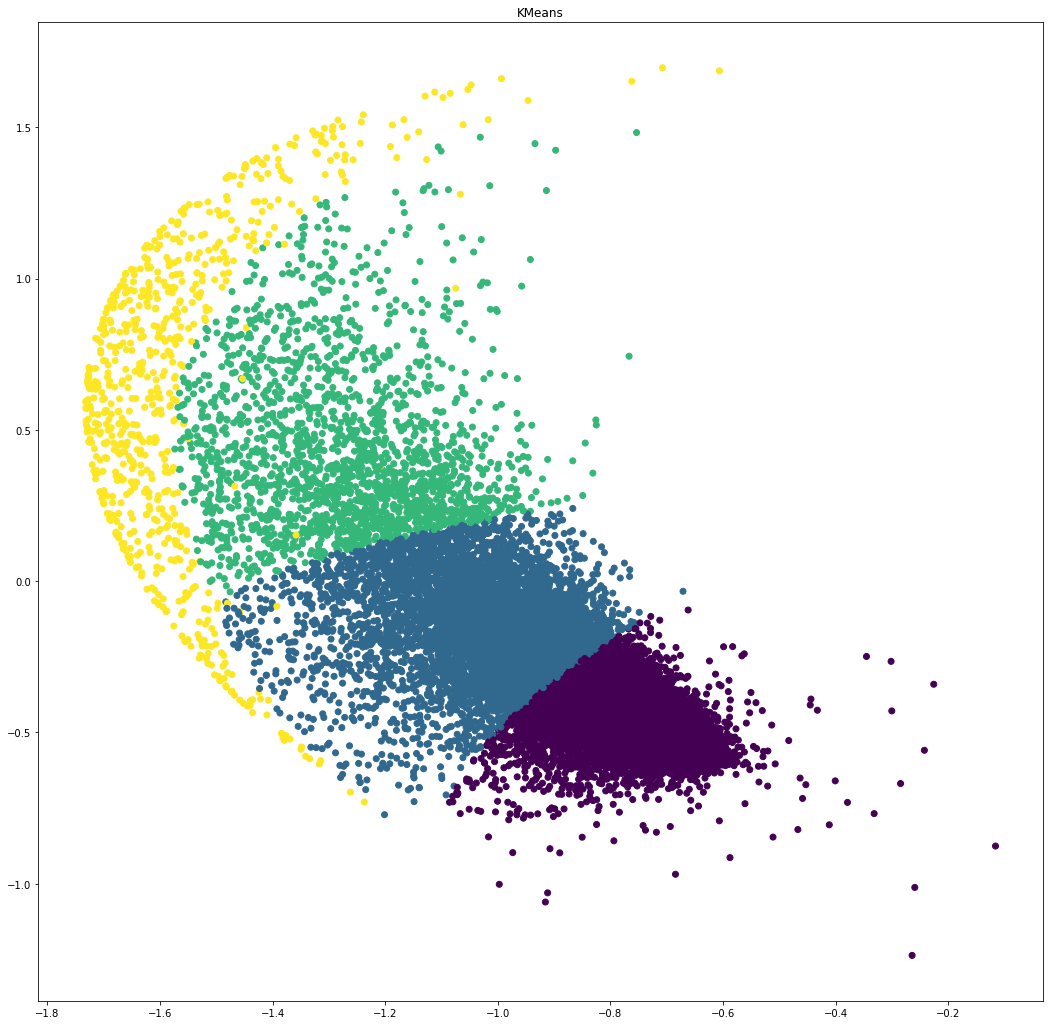

In [77]:
fig, ax = plt.subplots(figsize=(18, 18))
ax.scatter(data[:,1],data[:,3],c=y_pred)
plt.title("KMeans")

In [43]:
y_pred[80]

0

In [71]:
# Speichert Plot ab
fig.savefig('versuch2_KMeans')